In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  # Changed from joblib to pickle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, RocCurveDisplay, accuracy_score)
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

In [2]:
# Load and inspect data
df = pd.read_csv("..\dataset\parkinsons.csv")
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nClass distribution:")
print(df['status'].value_counts())


Dataset shape: (195, 24)

First 5 rows:
             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      R

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\skspa\AppData\Local\Temp\ipykernel_8404\2667713134.py:2: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("..\dataset\parkinsons.csv")


In [3]:
# Data preprocessing
df.drop('name', axis=1, inplace=True)

In [4]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


In [5]:
# Split features and target
X = df.drop('status', axis=1)
y = df['status']

In [6]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("\nClass distribution after SMOTE:", np.bincount(y_res))


Class distribution after SMOTE: [147 147]


In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)


In [8]:
# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [9]:
# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)


In [10]:
# Train model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 5, 10],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='recall', verbose=1)

In [11]:
# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


In [12]:
print("\nBest parameters:", grid_search.best_params_)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))


Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.98        29

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59

ROC AUC Score: 0.9988505747126437
Accuracy: 0.9830508474576272


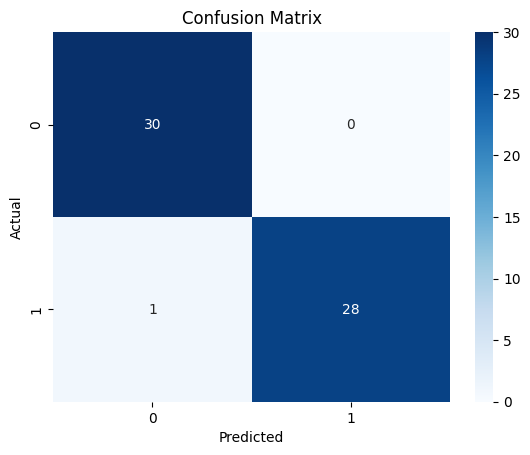

In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

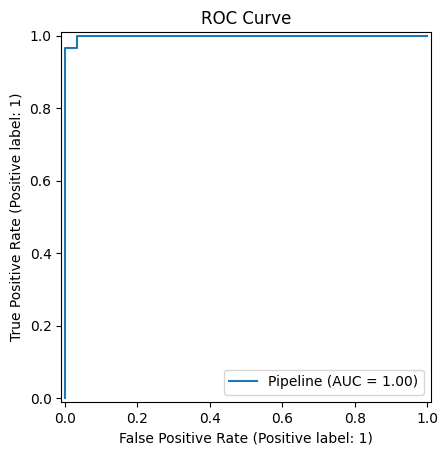

In [14]:
# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve')
plt.show()


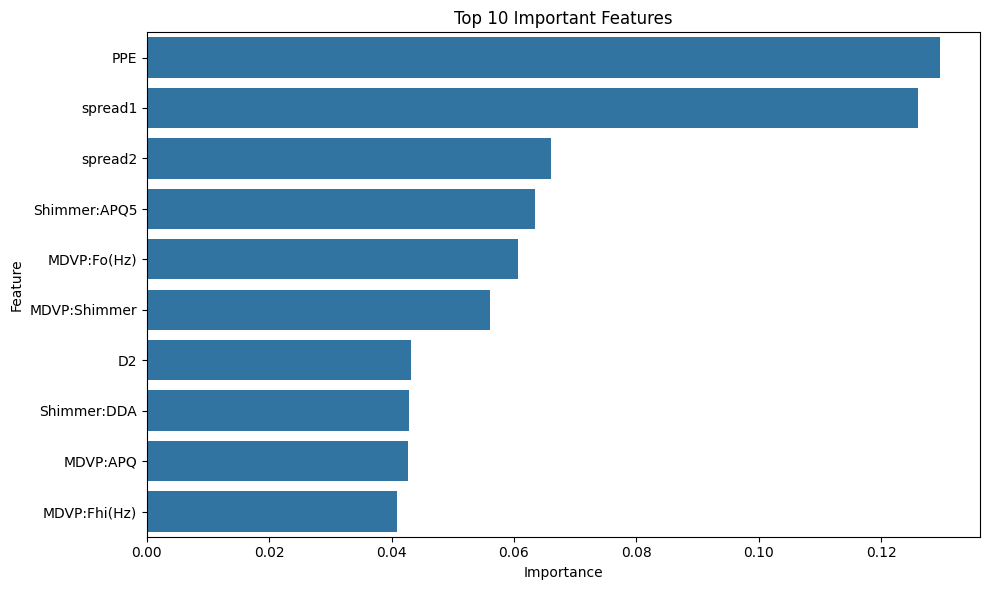

In [15]:
# Feature importance
feature_importances = best_model.named_steps['classifier'].feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()

In [17]:
with open('parkinsons_model.sav', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'scaler': best_model.named_steps['scaler'],
        
    }, f)

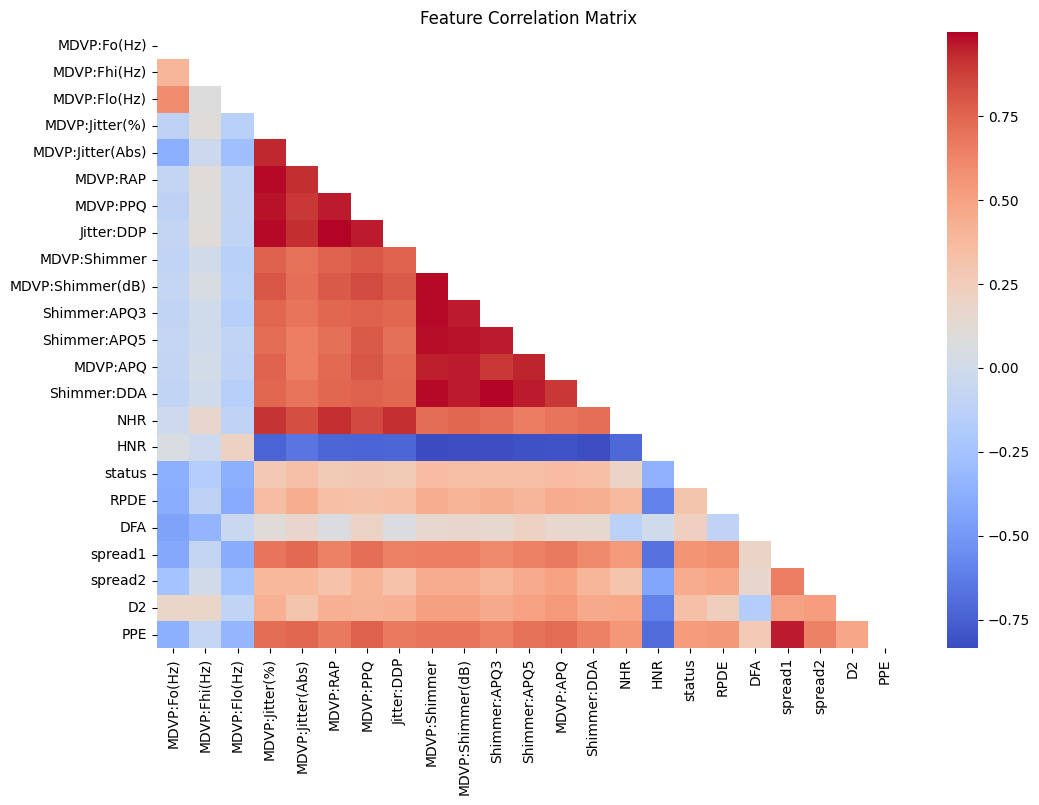

In [18]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Feature Correlation Matrix')
plt.show()